In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter‚Äôs stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

sma_pct_14  atr_pct_14    rsi_14   bb_w_20  plus_di_14  \
2004-01-02 09:33:00    0.499798    0.000000  1.000000  0.000000    0.000000   
2004-01-02 09:34:00    0.499798    0.000000  1.000000  0.000000    0.000000   
2004-01-02 09:35:00    0.499798    0.000000  1.000000  0.000000    0.000000   
2004-01-02 09:36:00    0.499798    0.000000  1.000000  0.000000    0.000000   
2004-01-02 09:37:00    0.499798    0.000000  1.000000  0.000000    0.000000   
...                         ...         ...       ...       ...         ...   
2025-06-18 20:56:00    0.751690    0.323886  0.672166  0.273759    0.363125   
2025-06-18 20:57:00    0.650094    0.336016  0.616686  0.290460    0.347207   
2025-06-18 20:58:00    0.631153    0.322169  0.614734  0.304199    0.336272   
2025-06-18 20:59:00    0.375519    0.346959  0.475401  0.305249    0.290578   
2025-06-18 21:00:00    0.535073    0.374297  0.551738  0.303059    0.249733   

                     range_pct    eng_ma  minus_di_14  eng_macd  \
2004-01-02 09:33:00   0.000000  0.516453     0.000000  0.624765   
2004-01-02 09:34:00   0.000000  0.516453     0.000000  0.624765   
2004-01-02 09:35:00   0.000000  0.516453     0.000000  0.624765   
2004-01-02 09:36:00   0.000000  0.516453     0.000000  0.624765   
2004-01-02 09:37:00   0.000000  0.516453     0.000000  0.624765   
...                        ...       ...          ...       ...   
2025-06-18 20:56:00   0.254109  0.532431     0.074852  0.634772   
2025-06-18 20:57:00   0.420131  0.532016     0.067044  0.633511   
2025-06-18 20:58:00   0.121620  0.531618     0.064933  0.631866   
2025-06-18 20:59:00   0.565110  0.531157     0.160021  0.623450   
2025-06-18 21:00:00   0.630630  0.531913     0.176984  0.622570   

                     macd_diff_12_26_9  body_pct  macd_line_12_26_9    volume  \
2004-01-02 09:33:00           0.506696  0.499412           0.489532  0.020724   
2004-01-02 09:34:00           0.506696  0.499412           0.489532  0.020724   
2004-01-02 09:35:00           0.506696  0.499412           0.489532  0.020724   
2004-01-02 09:36:00           0.506696  0.499412           0.489532  0.020724   
2004-01-02 09:37:00           0.506696  0.499412           0.489532  0.020724   
...                                ...       ...                ...       ...   
2025-06-18 20:56:00           0.888941  0.624850           0.971125  0.362651   
2025-06-18 20:57:00           0.840741  0.374057           0.981544  0.434283   
2025-06-18 20:58:00           0.777896  0.494766           0.983006  0.496049   
2025-06-18 20:59:00           0.456523  0.090577           0.884486  1.000000   
2025-06-18 21:00:00           0.422962  0.462226           0.868408  1.000000   

                     obv_diff_14  eng_rsi  eng_atr_div   eng_adx    adx_14  \
2004-01-02 09:33:00     0.488177      1.0     0.353456  0.519392  0.000000   
2004-01-02 09:34:00     0.488177      1.0     0.353456  0.519392  0.000000   
2004-01-02 09:35:00     0.488177      1.0     0.353456  0.519392  0.000000   
2004-01-02 09:36:00     0.488177      1.0     0.353456  0.519392  0.000000   
2004-01-02 09:37:00     0.488177      1.0     0.353456  0.519392  0.000000   
...                          ...      ...          ...       ...       ...   
2025-06-18 20:56:00     1.000000      0.0     0.664288  0.537709  0.301944   
2025-06-18 20:57:00     0.000000      0.0     0.676887  0.541855  0.328685   
2025-06-18 20:58:00     0.000000      0.0     0.584662  0.545337  0.353515   
2025-06-18 20:59:00     0.000000      0.0     0.645760  0.531521  0.348960   
2025-06-18 21:00:00     1.000000      0.0     0.708780  0.525575  0.336212   

                         hour      body   close_raw        signal  
2004-01-02 09:33:00  1.002425  0.506538    0.764286  6.967909e-09  
2004-01-02 09:34:00  1.002425  0.506538    0.764286  7.448270e-09  
2004-01-02 09:35:00  1.002425  0.506538    0.764286  7.961747e-09  
2004-01-02 09:36:00  1.002425  0.506538    0.764286  8.510623e-09  
2004-01-02 09:37:

In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.hparams["LOOK_BACK"],
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    train_workers  = params.hparams["TRAIN_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'eng_macd', 'macd_diff_12_26_9', 'body_pct', 'macd_line_12_26_9', 'volume', 'obv_diff_14', 'eng_rsi', 'eng_atr_div', 'eng_adx', 'adx_14', 'hour', 'body']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 3840  (2004-01-02 ‚Üí 2019-04-04)
 windows       : 1731840  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=20
 dataloader    : batches= 60, batch_size=64, workers=8, pin_memory=True

--- VAL ---
 calendar days : 751  (2019-04-05 ‚Üí 2022-03-28)
 windows       : 338701  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=20
 dataloader    : batches=751, batch_size=1, workers=0, pin_memory=True

--- TEST ---
 calendar days : 809  (2022-03-29 ‚Üí 2025-06-18)
 windows       : 364859  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=20
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True



In [5]:
# importlib.reload(params.model_selected) #############

# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = params.model_selected.ModelClass(
    n_feats         = len(params.features_cols_tick),
    short_units     = params.hparams["SHORT_UNITS"],
    long_units      = params.hparams["LONG_UNITS"],
    dropout_short   = params.hparams["DROPOUT_SHORT"],
    dropout_long    = params.hparams["DROPOUT_LONG"],
    pred_hidden     = params.hparams["PRED_HIDDEN"],
    window_len      = params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv          = params.hparams["USE_CONV"],
    use_tcn           = params.hparams["USE_TCN"],
    use_short_lstm    = params.hparams["USE_SHORT_LSTM"],
    use_transformer   = params.hparams["USE_TRANSFORMER"],
    use_long_lstm     = params.hparams["USE_LONG_LSTM"],
    flatten_mode      = params.hparams["FLATTEN_MODE"]
)

model.to(params.device)  

model

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (short_lstm): LSTM(20, 32, batch_first=True, bidirectional=True)
  (ln_short): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (do_short): Dropout(p=0.05, inplace=False)
  (feature_proj): Linear(in_features=64, out_features=64, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)


In [6]:
# # model check: overfit one batch: force your model to train on the exact same small set of examples over and over.
# # You should see loss ‚Üí 0 in a few dozen steps on a single batch.

# # 1) Grab a single batch (no shuffle issues)
# batch = next(iter(train_loader))
# x_pad, y_sig, *_, lengths = batch

# # 2) Move to device
# device = next(model.parameters()).device
# x_pad = x_pad.to(device)
# y_sig = y_sig.to(device)

# # 3) Extract just the first day‚Äôs valid windows
# #    lengths[0] might be a tensor or int
# W = lengths[0].item() if isinstance(lengths[0], torch.Tensor) else lengths[0]
# x_day = x_pad[0, :W]       # shape (W, features‚Ä¶)
# y_day = y_sig[0, :W]       # shape (W,)

# # 4) Our single target is the last tick of that day
# target_val = y_day[-1].unsqueeze(0)   # shape (1,)

# # 5) Turn off dropout so we can memorize perfectly
# for m in model.modules():
#     if isinstance(m, Dropout):
#         m.p = 0.0

# # 6) Clear any saved LSTM state (if your model uses h_short/h_long)
# if hasattr(model, "h_short"): model.h_short = None
# if hasattr(model, "h_long"):  model.h_long  = None

# # 7) Set up optimizer & loss
# optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.0)
# criterion = MSELoss()

# # 8) Overfit loop: reset state every pass, predict last‚Äêtick, compare scalar‚Üíscalar
# model.train()
# for step in range(100):
#     optimizer.zero_grad()

#     # reset hidden state each iteration
#     if hasattr(model, "h_short"): model.h_short = None
#     if hasattr(model, "h_long"):  model.h_long  = None

#     # forward on the full day sequence
#     raw_out = model(x_day)  
#     raw_reg = raw_out[0] if isinstance(raw_out, (tuple, list)) else raw_out

#     # collapse to shape (W,)
#     if raw_reg.dim() == 3:
#         raw_reg = raw_reg[0].squeeze(-1)
#     elif raw_reg.dim() == 2:
#         raw_reg = raw_reg.squeeze(-1)

#     # take *only* the final-tick prediction ‚Üí scalar
#     pred_val = raw_reg[-1].unsqueeze(0)   # shape (1,)

#     # compute scalar loss
#     loss = criterion(pred_val, target_val)
#     loss.backward()
#     optimizer.step()

#     if (step + 1) % 10 == 0 or step == 0:
#         print(f"Step {step+1:02d}  loss={loss.item():.6f}")


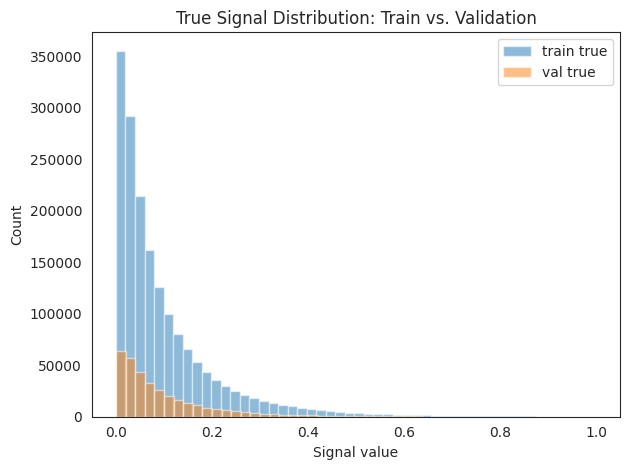

In [7]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])

# Visualize the true‚Äêsignal distributions on train vs. validation
plt.hist(y_train, bins=50, alpha=0.5, label="train true")
plt.hist(y_val,   bins=50, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3840 unique trading days per epoch.

Using HyperParameters:
 {'LOOK_BACK': 60, 'USE_CONV': False, 'CONV_K': 3, 'CONV_DILATION': 1, 'USE_TCN': False, 'TCN_LAYERS': 2, 'TCN_KERNEL': 3, 'USE_SHORT_LSTM': True, 'SHORT_UNITS': 64, 'DROPOUT_SHORT': 0.05, 'USE_TRANSFORMER': True, 'TRANSFORMER_LAYERS': 1, 'TRANSFORMER_HEADS': 4, 'TRANSFORMER_FF_MULT': 4, 'DROPOUT_LONG': 0.05, 'USE_LONG_LSTM': False, 'LONG_UNITS': 128, 'FLATTEN_MODE': 'last', 'PRED_HIDDEN': 64, 'ALPHA_SMOOTH': 0, 'SKIP_ALPHA': -10.0, 'MAX_EPOCHS': 70, 'EARLY_STOP_PATIENCE': 7, 'WEIGHT_DECAY': 0.0001, 'CLIPNORM': 20, 'ONECYCLE_MAX_LR': 0.003, 'ONECYCLE_DIV_FACTOR': 10, 'ONECYCLE_FINAL_DIV': 100, 'ONECYCLE_PCT_START': 0.15, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 64, 'VAL_BATCH': 1, 'TRAIN_WORKERS': 8, 'TRAIN_PREFETCH_FACTOR': 4}


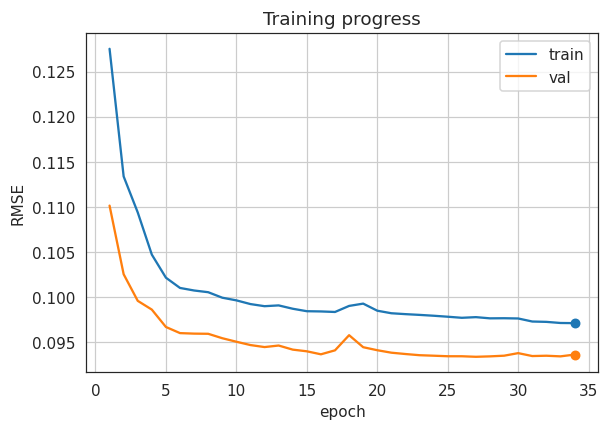

Epoch 1 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 01  TRAIN‚Üí RMSE=0.12754, R¬≤=-0.262 |  VALID‚Üí RMSE=0.11013, R¬≤=-0.007 |  lr=3.60e-04


Epoch 2 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 02  TRAIN‚Üí RMSE=0.11337, R¬≤=0.003 |  VALID‚Üí RMSE=0.10251, R¬≤=0.127 |  lr=5.35e-04


Epoch 3 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 03  TRAIN‚Üí RMSE=0.10937, R¬≤=0.072 |  VALID‚Üí RMSE=0.09955, R¬≤=0.177 |  lr=8.10e-04


Epoch 4 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 04  TRAIN‚Üí RMSE=0.10469, R¬≤=0.150 |  VALID‚Üí RMSE=0.09858, R¬≤=0.193 |  lr=1.16e-03


Epoch 5 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 05  TRAIN‚Üí RMSE=0.10212, R¬≤=0.191 |  VALID‚Üí RMSE=0.09665, R¬≤=0.224 |  lr=1.55e-03


Epoch 6 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 06  TRAIN‚Üí RMSE=0.10098, R¬≤=0.209 |  VALID‚Üí RMSE=0.09597, R¬≤=0.235 |  lr=1.95e-03


Epoch 7 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 07  TRAIN‚Üí RMSE=0.10070, R¬≤=0.213 |  VALID‚Üí RMSE=0.09591, R¬≤=0.236 |  lr=2.33e-03


Epoch 8 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 08  TRAIN‚Üí RMSE=0.10051, R¬≤=0.216 |  VALID‚Üí RMSE=0.09589, R¬≤=0.236 |  lr=2.64e-03


Epoch 9 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 09  TRAIN‚Üí RMSE=0.09990, R¬≤=0.226 |  VALID‚Üí RMSE=0.09540, R¬≤=0.244 |  lr=2.87e-03


Epoch 10 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 10  TRAIN‚Üí RMSE=0.09961, R¬≤=0.230 |  VALID‚Üí RMSE=0.09501, R¬≤=0.250 |  lr=2.99e-03


Epoch 11 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 11  TRAIN‚Üí RMSE=0.09919, R¬≤=0.236 |  VALID‚Üí RMSE=0.09464, R¬≤=0.256 |  lr=3.00e-03


Epoch 12 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 12  TRAIN‚Üí RMSE=0.09896, R¬≤=0.240 |  VALID‚Üí RMSE=0.09442, R¬≤=0.260 |  lr=3.00e-03


Epoch 13 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 13  TRAIN‚Üí RMSE=0.09905, R¬≤=0.239 |  VALID‚Üí RMSE=0.09459, R¬≤=0.257 |  lr=2.99e-03


Epoch 14 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 14  TRAIN‚Üí RMSE=0.09867, R¬≤=0.244 |  VALID‚Üí RMSE=0.09414, R¬≤=0.264 |  lr=2.97e-03
üîñ Saved folder‚Äêbest checkpoint (_chp): AAPL_0.09414_chp.pth


Epoch 15 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 15  TRAIN‚Üí RMSE=0.09840, R¬≤=0.249 |  VALID‚Üí RMSE=0.09395, R¬≤=0.267 |  lr=2.96e-03
üîñ Saved folder‚Äêbest checkpoint (_chp): AAPL_0.09395_chp.pth


Epoch 16 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 16  TRAIN‚Üí RMSE=0.09838, R¬≤=0.249 |  VALID‚Üí RMSE=0.09362, R¬≤=0.272 |  lr=2.94e-03
üîñ Saved folder‚Äêbest checkpoint (_chp): AAPL_0.09362_chp.pth


Epoch 17 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 17  TRAIN‚Üí RMSE=0.09832, R¬≤=0.250 |  VALID‚Üí RMSE=0.09406, R¬≤=0.265 |  lr=2.91e-03


Epoch 18 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 18  TRAIN‚Üí RMSE=0.09899, R¬≤=0.240 |  VALID‚Üí RMSE=0.09574, R¬≤=0.239 |  lr=2.88e-03


Epoch 19 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 19  TRAIN‚Üí RMSE=0.09924, R¬≤=0.236 |  VALID‚Üí RMSE=0.09440, R¬≤=0.260 |  lr=2.85e-03


Epoch 20 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 20  TRAIN‚Üí RMSE=0.09846, R¬≤=0.248 |  VALID‚Üí RMSE=0.09407, R¬≤=0.265 |  lr=2.81e-03


Epoch 21 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 21  TRAIN‚Üí RMSE=0.09817, R¬≤=0.252 |  VALID‚Üí RMSE=0.09379, R¬≤=0.269 |  lr=2.77e-03


Epoch 22 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 22  TRAIN‚Üí RMSE=0.09808, R¬≤=0.254 |  VALID‚Üí RMSE=0.09365, R¬≤=0.272 |  lr=2.73e-03


Epoch 23 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 23  TRAIN‚Üí RMSE=0.09799, R¬≤=0.255 |  VALID‚Üí RMSE=0.09352, R¬≤=0.274 |  lr=2.68e-03
üîñ Saved folder‚Äêbest checkpoint (_chp): AAPL_0.09352_chp.pth


Epoch 24 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 24  TRAIN‚Üí RMSE=0.09790, R¬≤=0.256 |  VALID‚Üí RMSE=0.09346, R¬≤=0.275 |  lr=2.63e-03
üîñ Saved folder‚Äêbest checkpoint (_chp): AAPL_0.09346_chp.pth


Epoch 25 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 25  TRAIN‚Üí RMSE=0.09779, R¬≤=0.258 |  VALID‚Üí RMSE=0.09340, R¬≤=0.275 |  lr=2.58e-03
üîñ Saved folder‚Äêbest checkpoint (_chp): AAPL_0.09340_chp.pth


Epoch 26 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 26  TRAIN‚Üí RMSE=0.09767, R¬≤=0.260 |  VALID‚Üí RMSE=0.09340, R¬≤=0.276 |  lr=2.52e-03
üîñ Saved folder‚Äêbest checkpoint (_chp): AAPL_0.09340_chp.pth


Epoch 27 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 27  TRAIN‚Üí RMSE=0.09774, R¬≤=0.259 |  VALID‚Üí RMSE=0.09334, R¬≤=0.276 |  lr=2.47e-03
üîñ Saved folder‚Äêbest checkpoint (_chp): AAPL_0.09334_chp.pth


Epoch 28 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 28  TRAIN‚Üí RMSE=0.09761, R¬≤=0.261 |  VALID‚Üí RMSE=0.09339, R¬≤=0.276 |  lr=2.40e-03


Epoch 29 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 29  TRAIN‚Üí RMSE=0.09762, R¬≤=0.260 |  VALID‚Üí RMSE=0.09346, R¬≤=0.275 |  lr=2.34e-03


Epoch 30 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 30  TRAIN‚Üí RMSE=0.09759, R¬≤=0.261 |  VALID‚Üí RMSE=0.09375, R¬≤=0.270 |  lr=2.27e-03


Epoch 31 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 31  TRAIN‚Üí RMSE=0.09726, R¬≤=0.266 |  VALID‚Üí RMSE=0.09342, R¬≤=0.275 |  lr=2.20e-03


Epoch 32 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 32  TRAIN‚Üí RMSE=0.09722, R¬≤=0.267 |  VALID‚Üí RMSE=0.09346, R¬≤=0.275 |  lr=2.13e-03


Epoch 33 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 33  TRAIN‚Üí RMSE=0.09709, R¬≤=0.268 |  VALID‚Üí RMSE=0.09339, R¬≤=0.276 |  lr=2.06e-03


Epoch 34 ‚ñ∂ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 34  TRAIN‚Üí RMSE=0.09708, R¬≤=0.269 |  VALID‚Üí RMSE=0.09358, R¬≤=0.273 |  lr=1.99e-03
Early stopping at epoch 34
‚úÖ Final‚Äêbest model saved: AAPL_0.09334_fin.pth


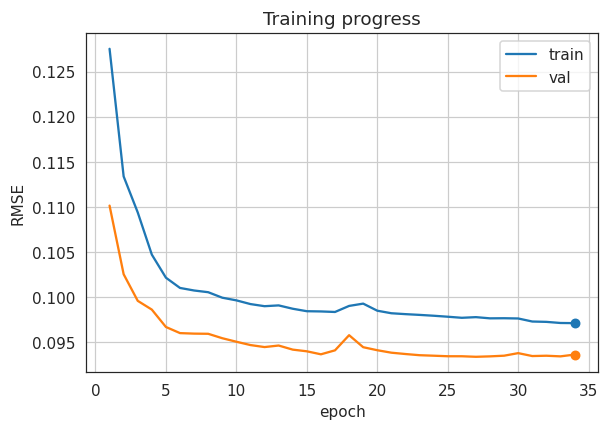

In [8]:
importlib.reload(params) #############
importlib.reload(params.model_selected) #############
importlib.reload(models_core) #############

# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

print('Using HyperParameters:\n', params.hparams)

optimizer = AdamW(
  model.parameters(),
  lr           = params.hparams["ONECYCLE_MAX_LR"],
  weight_decay = params.hparams["WEIGHT_DECAY"]
)

scheduler = OneCycleLR(
  optimizer,
  max_lr           = params.hparams["ONECYCLE_MAX_LR"],
  total_steps      = len(train_loader)*params.hparams["MAX_EPOCHS"], # batches √ó epochs
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = params.model_selected.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = params.hparams['CLIPNORM'],
    alpha_smooth        = params.hparams['ALPHA_SMOOTH']
)
